 <font size="6">  Image segmentation training - Mask R-CNN </font> 

---

In this notebook, we will show how to train a deep learning model to do instance segmentation

## Set path and Load library

In [1]:
from mrcnn.main import *
# Set path to Mask RCNN folder
ROOT_DIR = os.path.abspath(r"/home/cap6412.student23/MaskRCNN_cell")
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


In [ ]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 
from mrcnn.config import Config
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Load data

Input training and validation image path here. Validation dataset may be left blank. Note that all training images must be of equal size and square. The variable 'size' corresponds to the image shape: (size, size, 3). 

In [41]:
#Training images should be square
size=256
images = sorted((glob.glob(r"/home/cap6412.student23/MaskRCNN_cell/notebook/trainingDataRound2B/*Nuclei.jpg")))
labels = sorted((glob.glob(r"/home/cap6412.student23/MaskRCNN_cell/notebook/trainingDataRound2B/*ome.tiff")))
images_augmented = sorted((glob.glob(r"/home/cap6412.student23/MaskRCNN_cell/notebook/trainingDataRound2B/Augmented/Nuclei/*.jpg")))
labels_augmented = sorted((glob.glob(r"/home/cap6412.student23/MaskRCNN_cell/notebook/trainingDataRound2B/Augmented/Masks/*.tiff")))
images = images + images_augmented
labels = labels + labels_augmented
images_val = sorted((glob.glob(r"/home/cap6412.student23/MaskRCNN_cell/notebook/val2B/*Nuclei.jpg")))
labels_val = sorted((glob.glob(r"/home/cap6412.student23/MaskRCNN_cell/notebook/val2B/*ome.tiff")))


340

If validation dataset does not exist, fill it in with the same variables as the training dataset. Fields cannot be left blank.

## Set parameters for training

Key parameter
* GPU count
* IMAGES_PER_GPU
* DETECTION_MAX_INSTANCES: max instance in one image
* IMAGE_MIN_DIM: random cropping will be performed on the input image to this size. I recommend 128 for 200X image.


In [22]:
class CellConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cell"
    BACKBONE = 'resnet50'
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 2
    IMAGES_PER_GPU = 2
    #RPN_NMS_THRESHOLD = 0.8
    DETECTION_MAX_INSTANCES = 256 #500
    MAX_GT_INSTANCES = 256
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 cell
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128 #128
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256 #1024 #256 #1024 #256
    IMAGE_RESIZE_MODE = 'crop'
    ROI_POSITIVE_RATIO = 0.33
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 320 #1000 #320 #1000 #320 # 80
    #LOSS_WEIGHTS  ={}
    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 1000 #1000 (for a comprehensive training, 1000 is recommended)
    # use small validation steps since the epoch is small
    VALIDATION_STEPS =50# 10 #5
    MEAN_PIXEL = np.array([0,0,0])  #([45,25,40]) # based on your own data

    # ALSO CHANGED CONFIG.PY to change IMAGE SHAPE
    
    
config = CellConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        256
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES   

## Load data and configuration into model

Image Count: 40
Class Count: 2
  0. BG                                                
  1. cell                                              


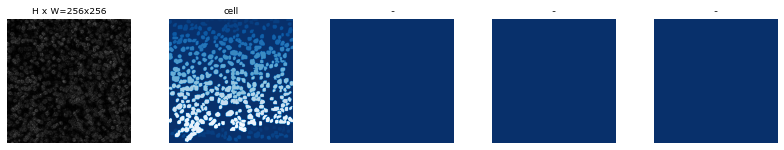

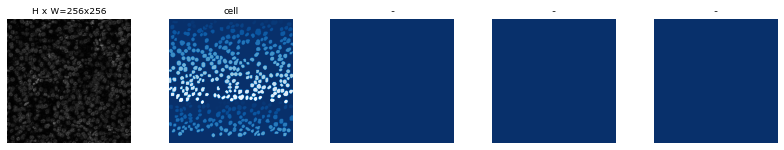

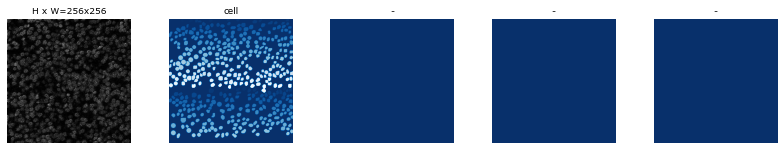

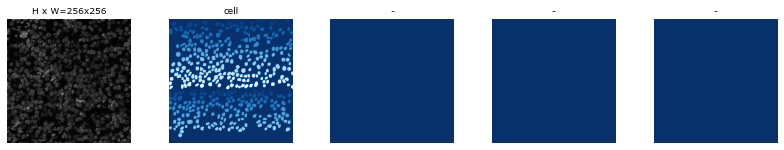

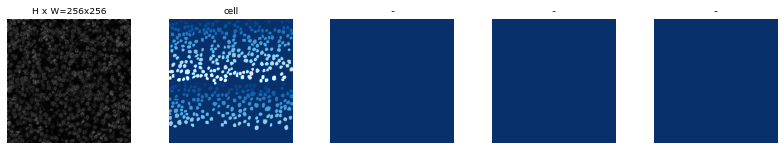

In [23]:
config = CellConfig()
#config.display()

# Training dataset
dataset_train = CellDataset()
dataset_train.setImages(images)
dataset_train.setLabels(labels)
dataset_train.setSize(size)
dataset_train.load_cells('dummy_path')
dataset_train.prepare()

#All entries must be nonzero!
# Validation dataset
dataset_val = CellDataset()
dataset_val.setImages(images)
dataset_val.setLabels(labels)
dataset_val.setSize(size)
dataset_val.load_cells('dummy_path')
dataset_val.prepare()

print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    
for i in range(0,min(len(images),5)):
    image = dataset_train.load_image(i)
    mask, class_ids = dataset_train.load_mask(i)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


## Training configuration

### Model backend and Pre-trained weights

In [24]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)
#Which weights to start with?
init_with = "imagnet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

### Data Augmentation

In [25]:
#Data Augmentation

augmentation = iaa.SomeOf((0, 5), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
        iaa.Affine(rotate=(-90,90)),
    iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0.0,5.0)))
    ,iaa.Sometimes(0.2, iaa.Affine(scale={"x": (0.7, 1.5), "y": (0.7, 1.5)})),
    iaa.Sometimes(0.2,  iaa.Multiply((0.7, 1.5))),
    iaa.Sometimes(0.1, iaa.Affine(shear=(-45, 45)))
])

## Train

### Train on the heads layers

In [26]:
#Run "tensorboard --logdir logs/" in terminal to visualize results
#Default Port #: 6006

model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=10,augmentation=augmentation,
            layers='heads') #all heads

model_path = model.find_last()
print("Last trained model path: " + str(model_path))


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\home\ubuntu\github\MaskRCNN\logs\cell20220413T2358\mask_rcnn_cell_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn

KeyboardInterrupt: 

### Train on all layers

In [14]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20,augmentation=augmentation,
            layers='all') #all




Starting at epoch 10. LR=0.001

Checkpoint Path: /home/ubuntu/github/MaskRCNN/logs/cell20191219T1724/mask_rcnn_cell_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_b

### Train on all layers with lower learning rate

In [17]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/10, 
            epochs=30,augmentation=augmentation,
            layers='all') #all





Starting at epoch 20. LR=0.0001

Checkpoint Path: /home/ubuntu/github/MaskRCNN/logs/cell20191219T1724/mask_rcnn_cell_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_